In [1]:
import sys
sys.path.append('./')
import tissue_utils as utils
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multitest import fdrcorrection

from matplotlib import rc
rc('text', usetex=False)
# rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 20, 
      'axes.titlesize': 20, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("ticks")

mpl.rcParams['xtick.labelsize'] = 23
mpl.rcParams['ytick.labelsize'] = 23 
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams["legend.title_fontsize"] = 22

# load stuff:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
# keep DE genes only:
res = res[((res['padj-58'] < 0.05) | (res['padj-50'] < 0.05)) & (res['Sign-WT'] == 'Same')] 

cols = ['externalgenename', 'log2FoldChange{0}', 'padj{0}']
fetch = lambda x: [c.format(x) for c in cols]
rename = lambda x: {'log2FoldChange{0}'.format(x): 'log2FoldChange', 'padj{0}'.format(x): 'padj'}

# data wrangling to create a new dataframe that contains the `results` data, but will also include
# the tissue annotations
a = res[fetch('-58')].rename(columns=rename('-58'))
b = res[fetch('-50')].rename(columns=rename('-50'))
a['data'] = '58hrs'
b['data'] = '50hrs'
annotated_data = pd.concat([a[a.padj < 0.05], b[b.padj < 0.05]])
cat_type = pd.CategoricalDtype(categories=['50hrs', '58hrs'], ordered=True)
annotated_data.data = annotated_data.data.astype(cat_type)

# load tissue dictionary:
tissues = utils.load_tissues(res.index, 5, 30)
annotated_data = annotated_data.join(tissues.set_index('wbid')).dropna(subset=['tissue'])
annotated_data.head()
# res

tissues originally: 1535
tissues afterwards: 264


,externalgenename,log2FoldChange,padj,data,external_gene_name,target_id,species,tissue
WBGene00000001,aap-1,0.096256,0.009407,58hrs,aap-1,Y110A7A.10,Caenorhabditis elegans,body wall musculature
WBGene00000001,aap-1,0.096256,0.009407,58hrs,aap-1,Y110A7A.10,Caenorhabditis elegans,hypodermis
WBGene00000001,aap-1,0.096256,0.009407,58hrs,aap-1,Y110A7A.10,Caenorhabditis elegans,intestine
WBGene00000001,aap-1,0.096256,0.009407,58hrs,aap-1,Y110A7A.10,Caenorhabditis elegans,neuron
WBGene00000023,abt-5,-0.342206,0.000949,50hrs,abt-5,Y53C10A.9,Caenorhabditis elegans,head


In [2]:
# perform a binomial test for change in direction:
alpha = 0.05
data = utils.test_tissue_direction(res[res['padj-58'] < 0.05], tissues)
data_50 = utils.test_tissue_direction(res[res['padj-50'] < 0.05], tissues, col='log2FoldChange-50')

data = pd.concat([data, data_50], keys=['58hrs', '50hrs']
                ).reset_index().rename(
                columns={'level_0': 'data'}
                ).drop('level_1', axis=1)

data = utils.fdr_correct(data)
data.sort_values('fdr', inplace=True)

data['MeanFracPos'] = data.groupby(['tissue', 'data']).FracPos.transform(np.mean)
data['MeanFracPos'] = data.groupby(['tissue', 'data']).FracPos.transform(np.mean)

# keep only significant results:
keep = data.groupby('tissue').sig.sum()
data = data[data.tissue.isin(keep[keep > 0].index)]

m = 'There were {0} tissues that changed more in one direction than expected by random chance in dataset {1}'
for n, g in data.groupby('data'):
    print(m.format(len(g), n))
    
data

There were 46 tissues that changed more in one direction than expected by random chance in dataset 50hrs
There were 49 tissues that changed more in one direction than expected by random chance in dataset 58hrs


,data,tissue,pval,FracPos,FracPosExpected,fdr,neglogq,sig,MeanFracPos
0,58hrs,germ line,2.449246e-24,0.953125,0.646552,7.151798e-22,21.145585,True,0.953125
1,58hrs,Cell,1.625358e-11,0.938776,0.646552,2.373022e-09,8.624698,True,0.938776
2,58hrs,nervous system,2.933895e-10,0.828000,0.646552,2.855658e-08,7.544294,True,0.828000
3,58hrs,body wall musculature,8.520268e-10,0.808581,0.646552,6.219796e-08,7.206224,True,0.808581
194,50hrs,reproductive system,1.626558e-09,0.901099,0.615059,9.499100e-08,7.022318,True,0.901099
...,...,...,...,...,...,...,...,...,...
102,58hrs,spermatid,2.527991e-01,0.428571,0.646552,4.824663e-01,0.316533,False,0.428571
269,50hrs,hyp9,6.819123e-01,0.500000,0.615059,8.473123e-01,0.071956,False,0.500000
263,50hrs,hyp11,6.819123e-01,0.500000,0.615059,8.473123e-01,0.071956,False,0.500000
270,50hrs,somatic cell,7.188394e-01,0.750000,0.615059,8.856587e-01,0.052734,False,0.750000


In [3]:
remove = ['Cell', 'tail', 'head', 'male gonad', 'gonad', ]  # so broad. why ever have these terms...
remove = utils.similarity_trimming(data.tissue.unique(), tissues, remove)
print('The following list of tissues will be removed from the plot', list(set(remove)))

The following list of tissues will be removed from the plot ['mu-int-R', 'tail', 'P0', 'hyp12', 'ventral cord neuron', 'excretory cell', 'ABp', 'Z2', 'rectal epithelium', 'hyp11', 'Psub1', 'ABa', 'AB', 'anterior distal tip cell', 'hermaphrodite gonad', 'reproductive system', 'hypodermis', 'mu-int-L', 'anal depressor muscle', 'male gonad', 'Psub3', 'Psub2', 'Z3', 'body region', 'head', 'Cell', 'posterior distal tip cell', 'nervous system', 'vulval muscle', 'gonad', 'EMS', 'phasmid neuron', 'tail neuron']


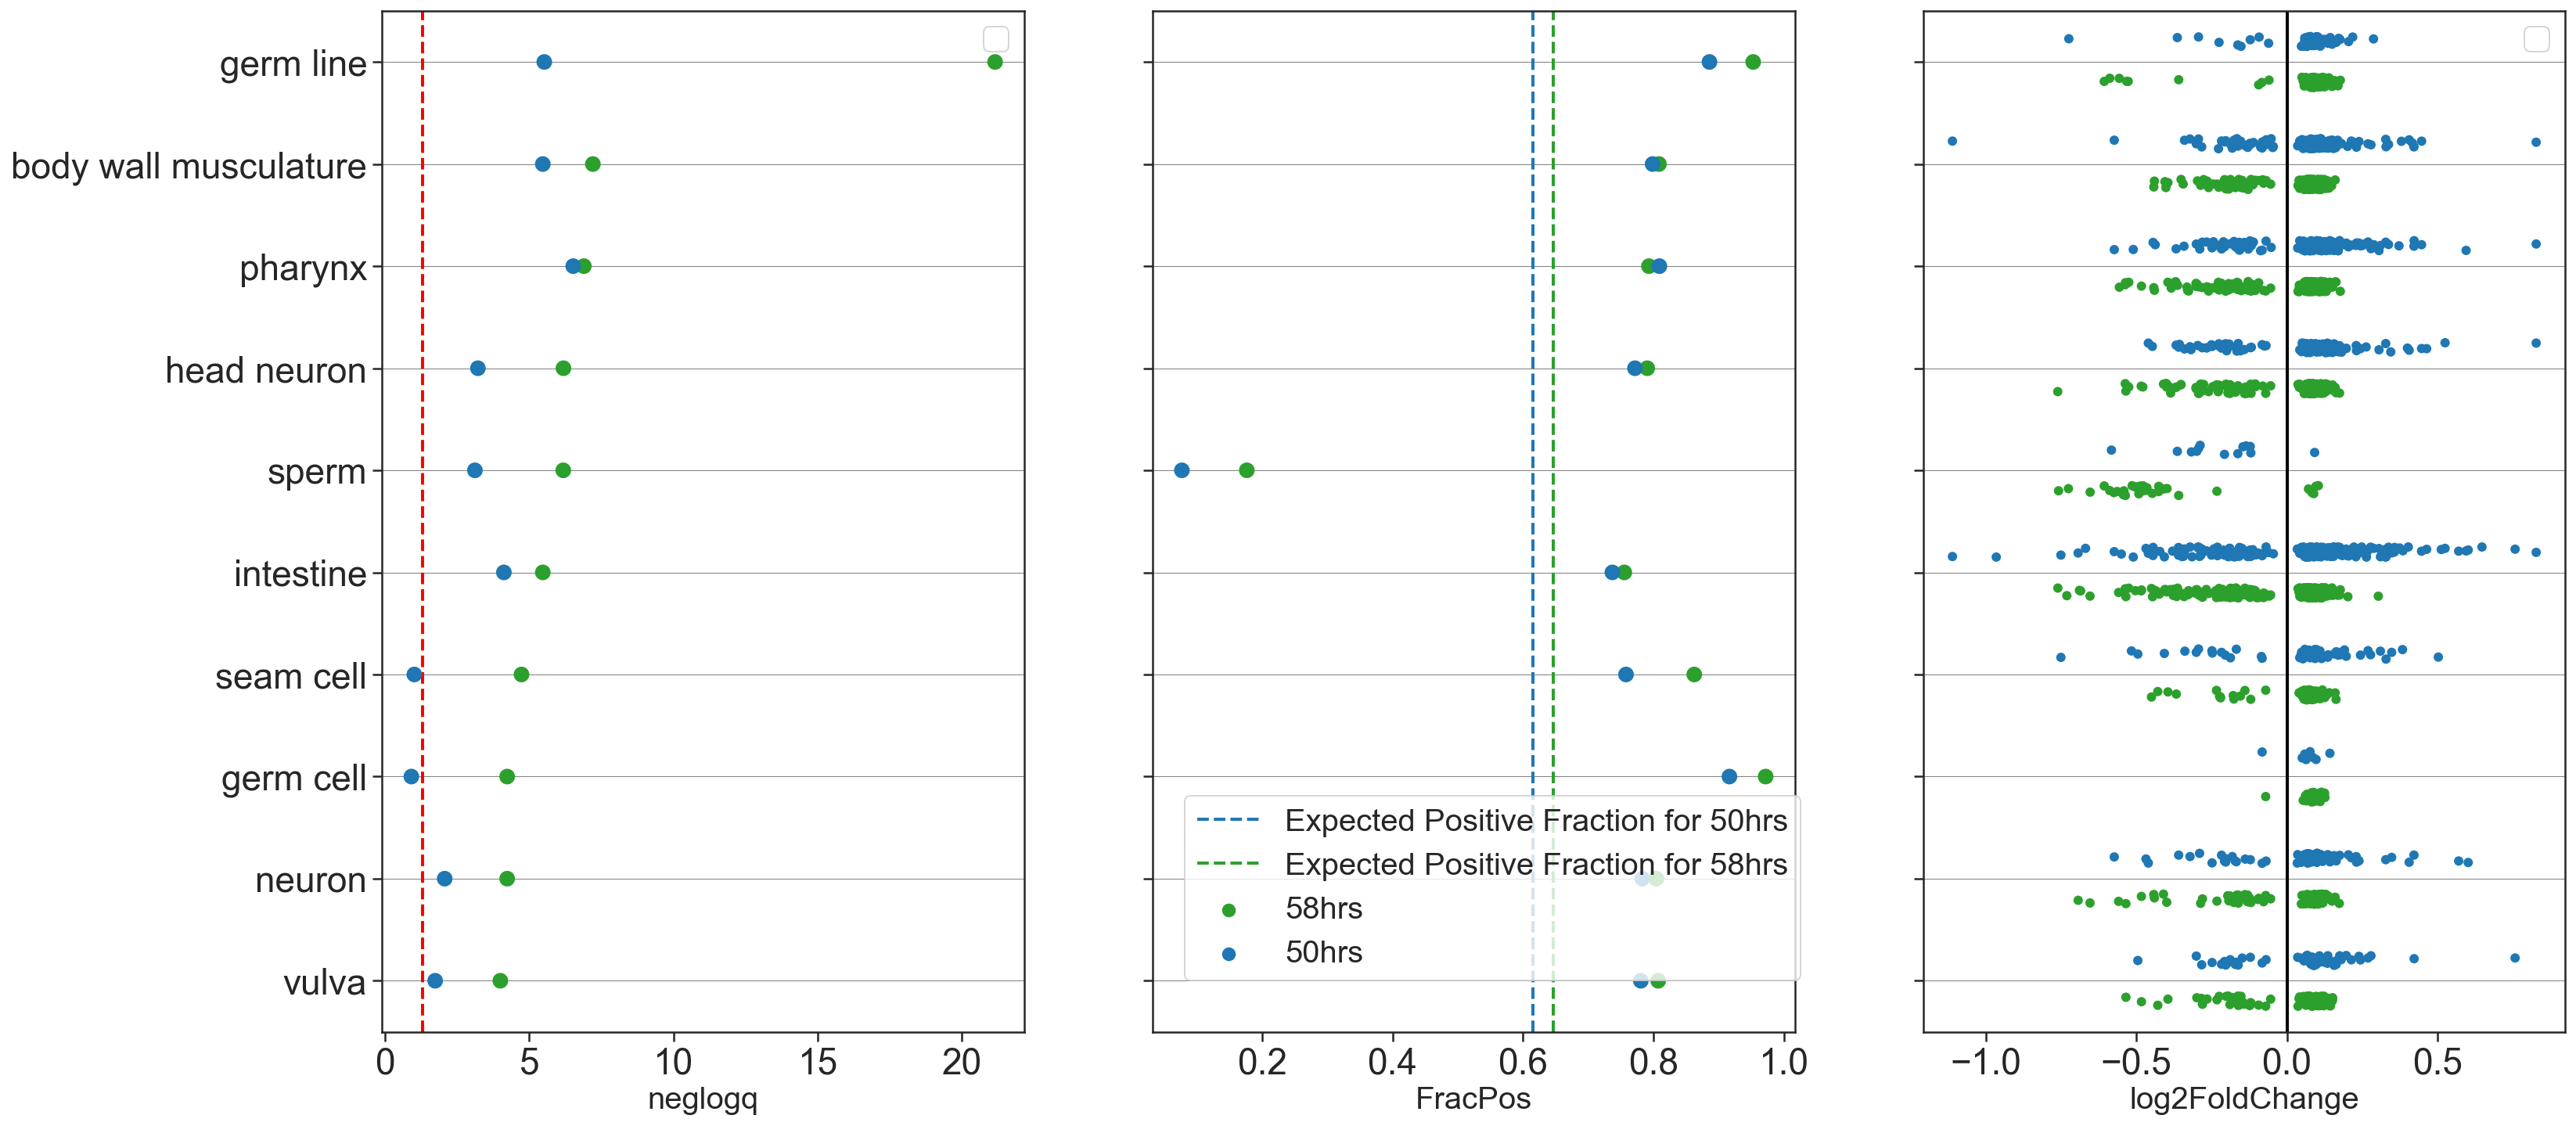

In [4]:
to_plot = data[(~data.tissue.isin(remove)) & (data.sig == True)].head(15)#.sort_values('fdr').head(10)
to_plot = data[(data.tissue.isin(to_plot.tissue))]

tissues_plotted = to_plot.tissue.unique()
fig, ax, legend = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha)

plt.savefig('../figs/tissue_GSEA.svg', bbox_inches='tight', transparent=True)

In [5]:
# load stuff:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
# keep DE genes only:
res = res[(res['padj-pqm1'] < 0.05)] 

tissues = utils.load_tissues(res.index, 5, 30)
res = res.reindex(tissues.wbid.unique()).dropna()

alpha = 0.05
data = utils.test_tissue_direction(res, tissues=tissues,
                                   col='log2FoldChange-pqm1')
data = utils.fdr_correct(data)
data.sort_values('fdr', inplace=True)

data['MeanFracPos'] = data.groupby('tissue').FracPos.transform(np.mean)

m = 'There were {0} tissues that changed more in one direction than expected by random chance in dataset {1}'
print(m.format(len(data[data.sig == True]), n))

tissues originally: 2130
tissues afterwards: 736
There were 30 tissues that changed more in one direction than expected by random chance in dataset 58hrs


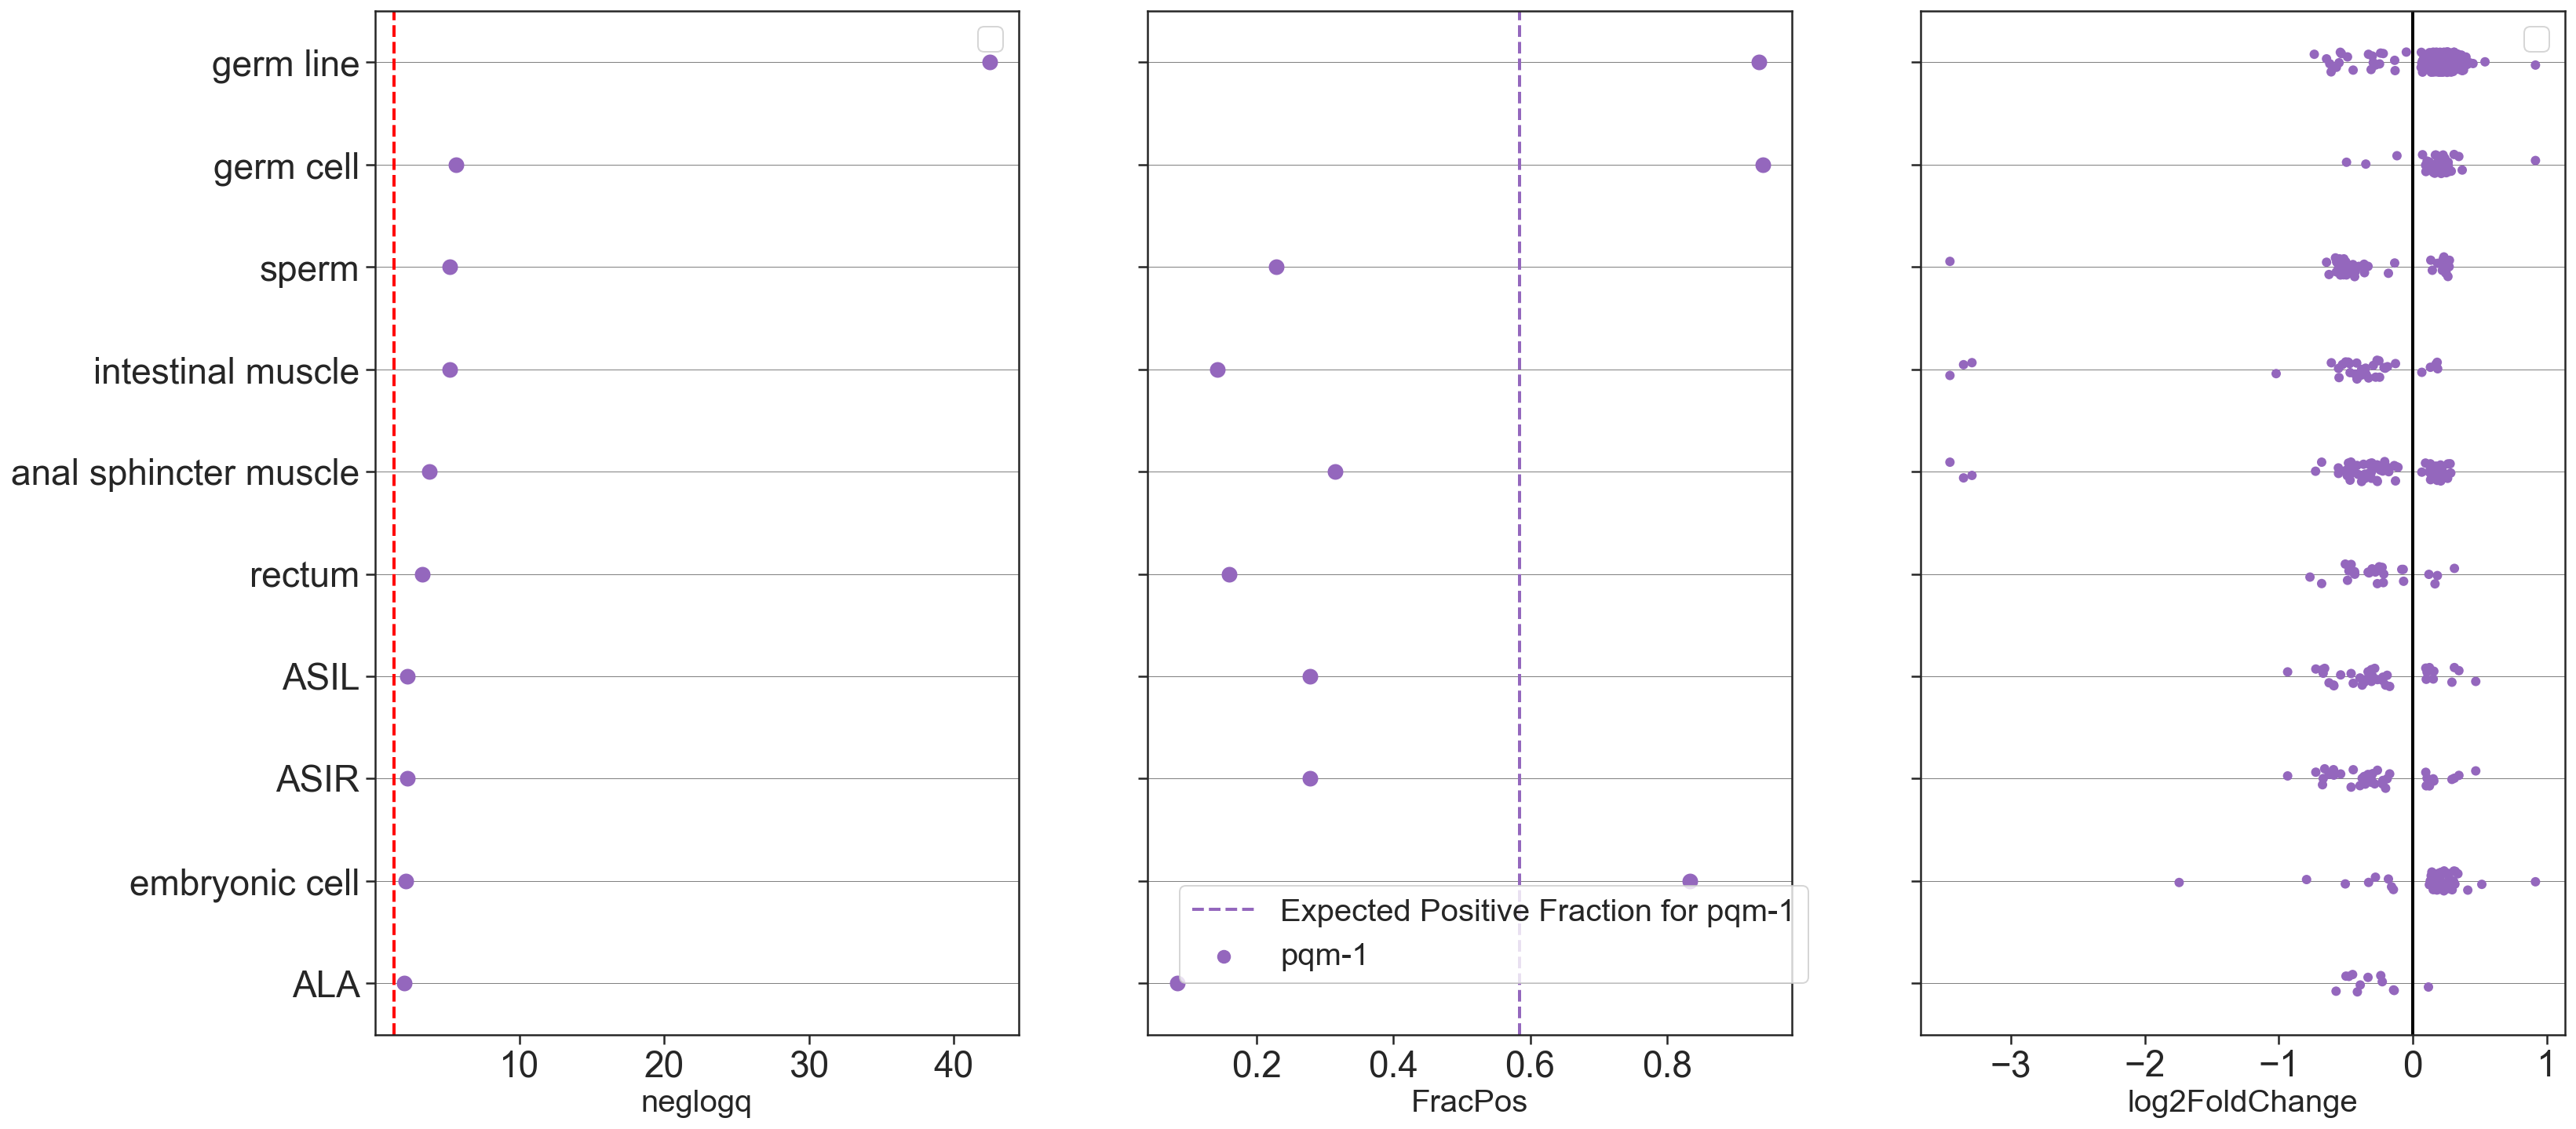

In [6]:
data['data'] = 'pqm-1'
to_plot = data[(~data.tissue.isin(remove)) & (data.sig == True)].head(10)#.sort_values('fdr').head(10)
annotated_data = res.join(tissues.set_index('wbid'))
annotated_data['data'] = 'pqm-1'
annotated_data.rename(columns={'log2FoldChange-pqm1':'log2FoldChange'}, inplace=True)

fig, ax, legend = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha, hue='data', palette={'pqm-1': 'tab:purple'})

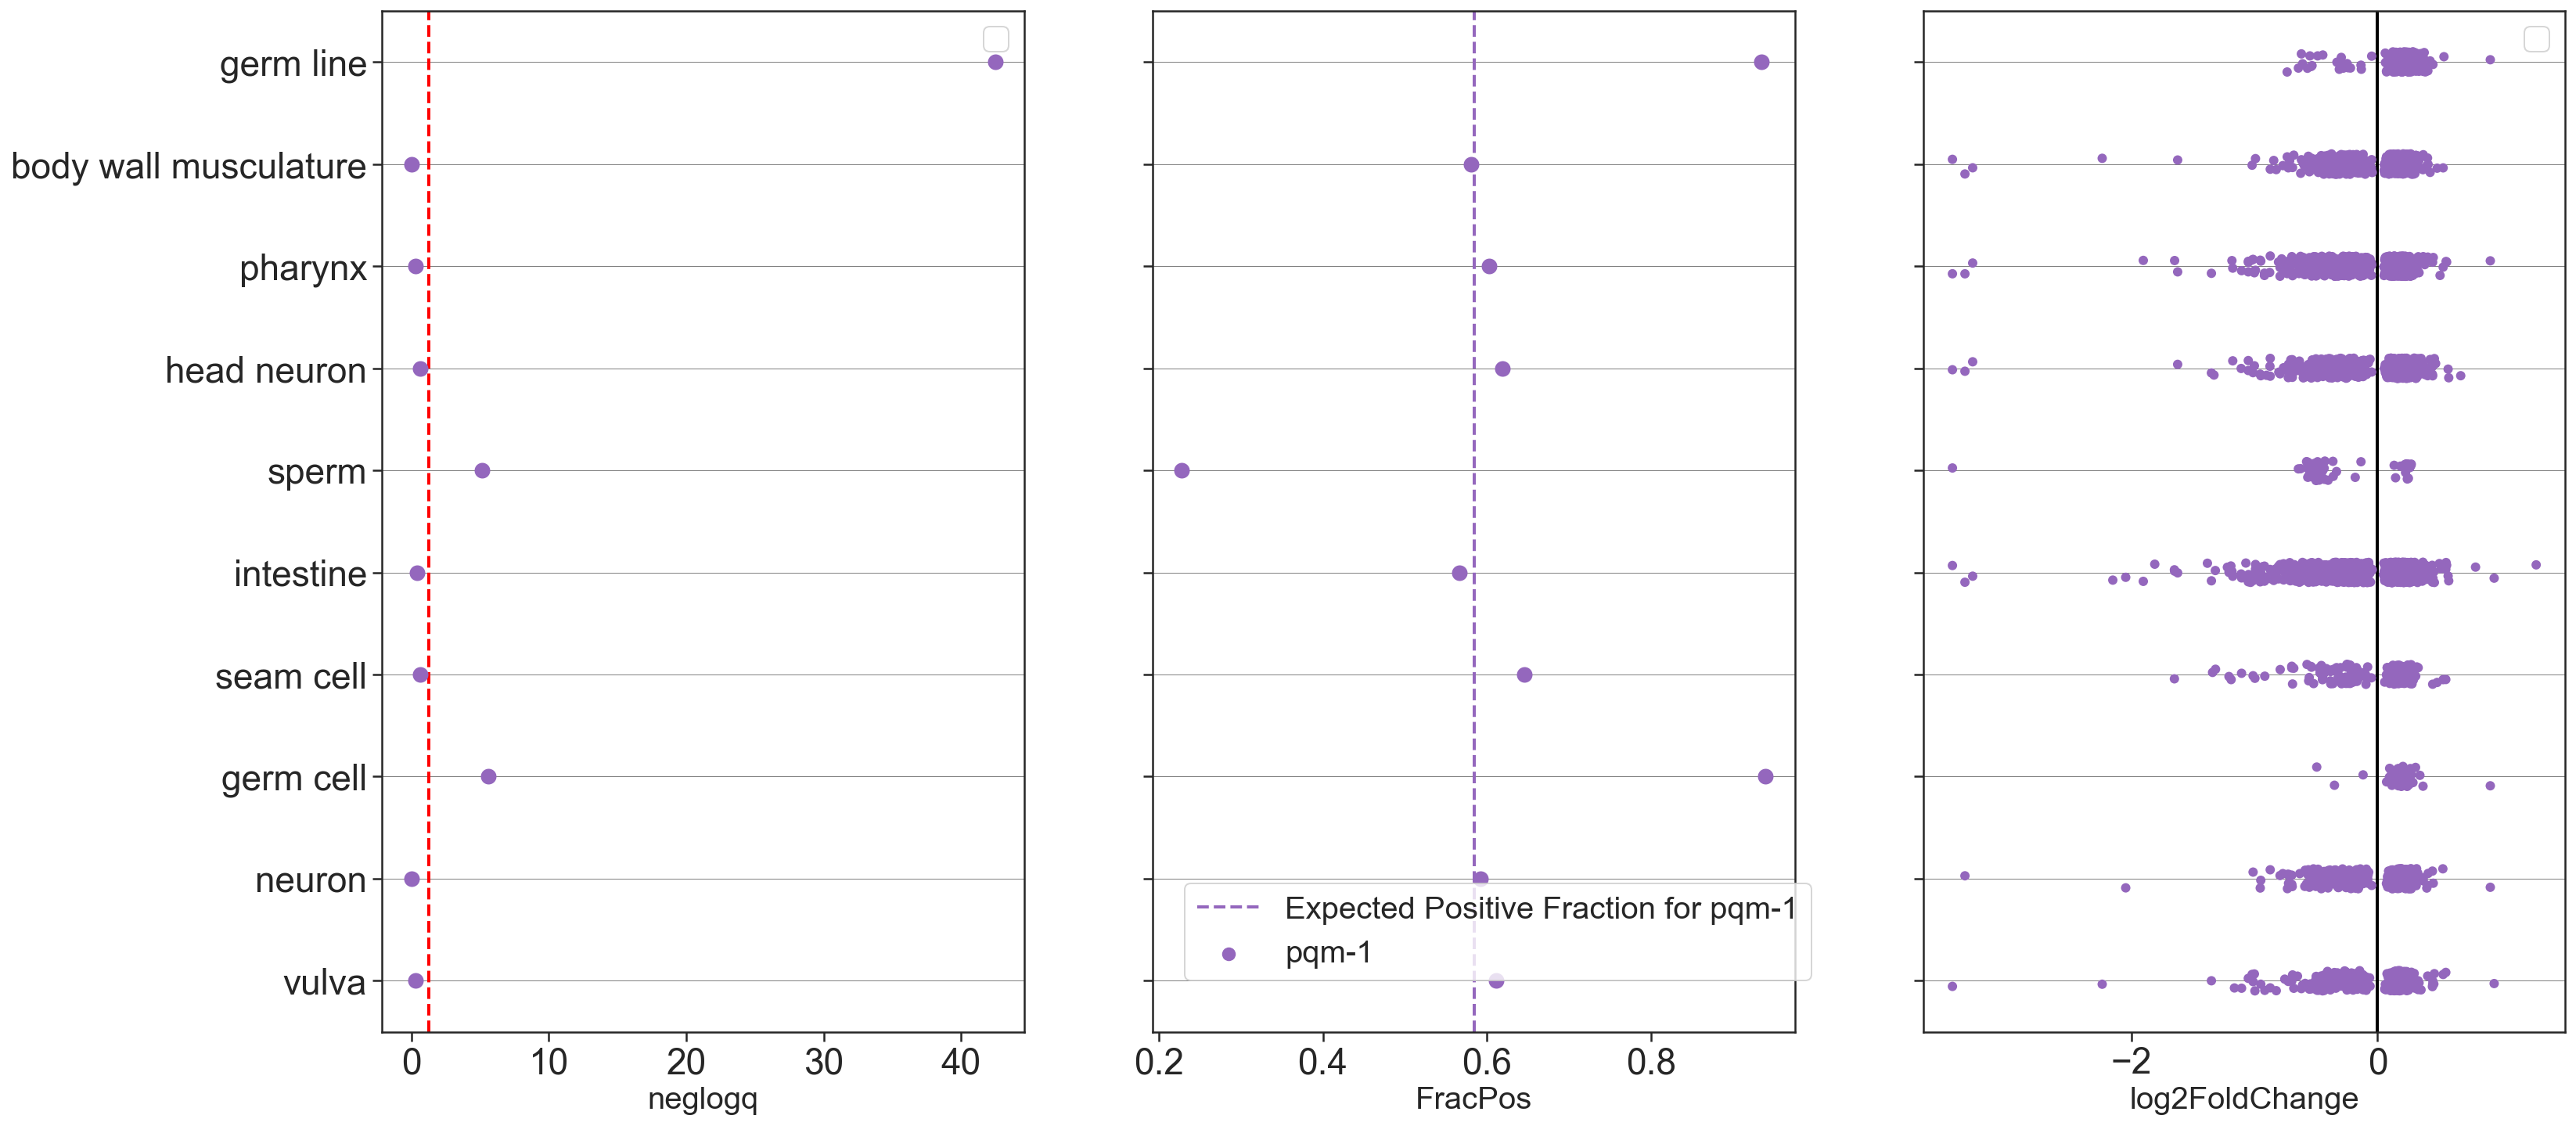

In [7]:
to_plot = data[(~data.tissue.isin(remove)) & (data.tissue.isin(tissues_plotted))].copy()
to_plot.tissue = to_plot.tissue.astype('category')
to_plot.tissue.cat.set_categories(tissues_plotted, inplace=True)
to_plot.sort_values('tissue', inplace=True)

fig, ax, legend = utils.pretty_GSEA_plots(to_plot, annotated_data, alpha, hue='data', palette={'pqm-1': 'tab:purple'})

In [8]:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
res = res.dropna(subset=['log2FoldChange-50', 'log2FoldChange-pqm1'])
tissues = utils.load_tissues(res.index, 5, 30)
annotated_data = res.join(tissues.set_index('wbid')).dropna(subset=['tissue'])

tissues originally: 2359
tissues afterwards: 846


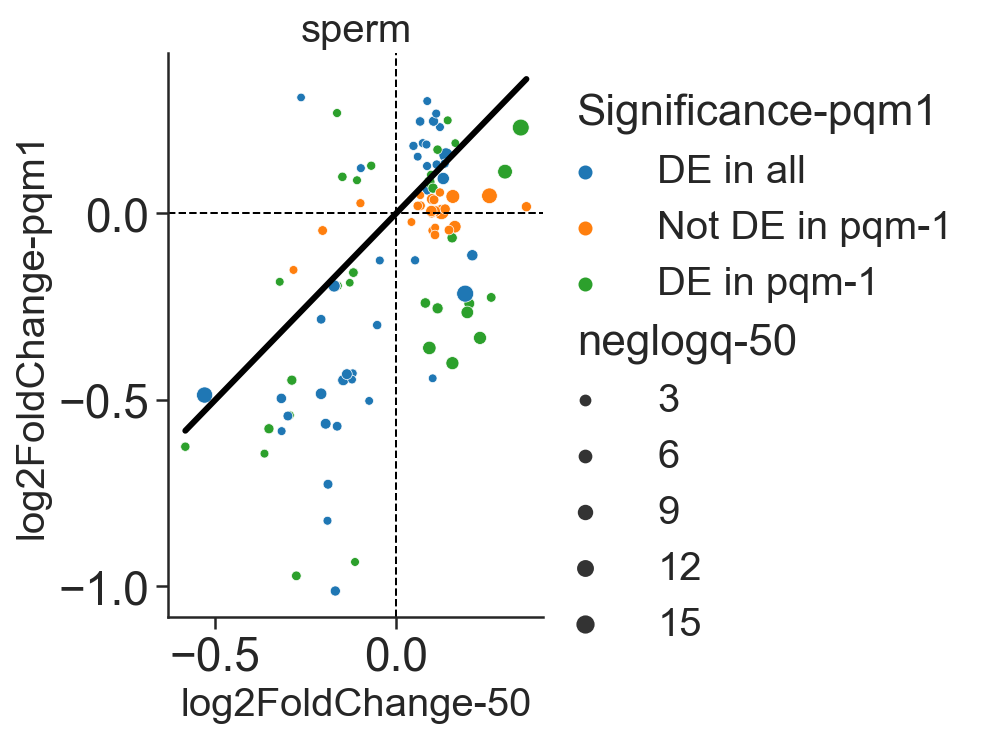

In [9]:
x = 'log2FoldChange-50'
y = 'log2FoldChange-pqm1'
utils.corr_plots(annotated_data, x, y, hue='Significance-pqm1', size='neglogq-50',
                 tissue='sperm', qval=0.05, kind='pearson')

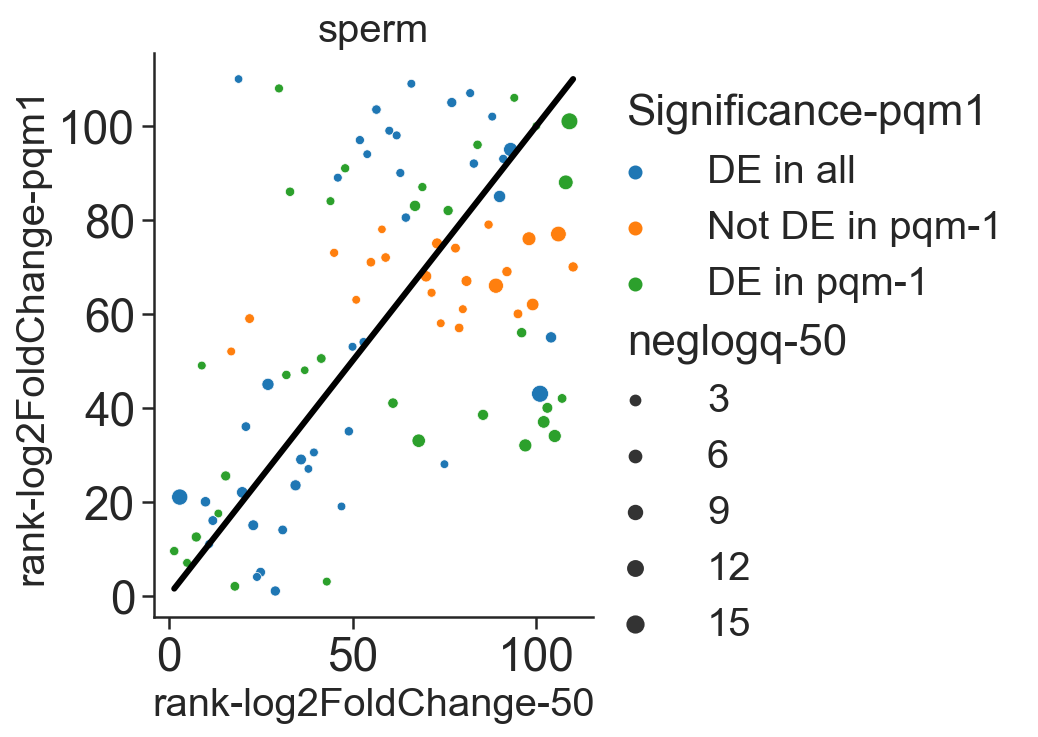

In [10]:
utils.corr_plots(annotated_data, x, y, hue='Significance-pqm1', size='neglogq-50',
                 tissue='sperm', qval=0.05, kind='rank')

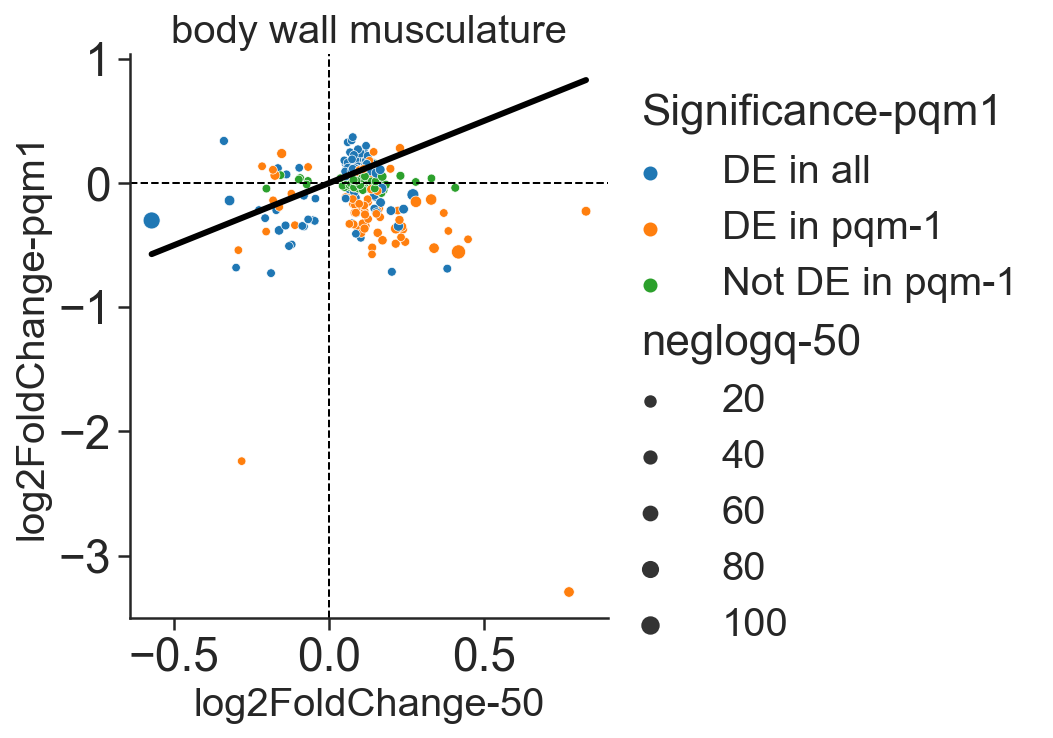

In [11]:
utils.corr_plots(annotated_data, x, y, hue='Significance-pqm1', size='neglogq-50',
                 tissue='body wall musculature', qval=0.05, kind='pearson')

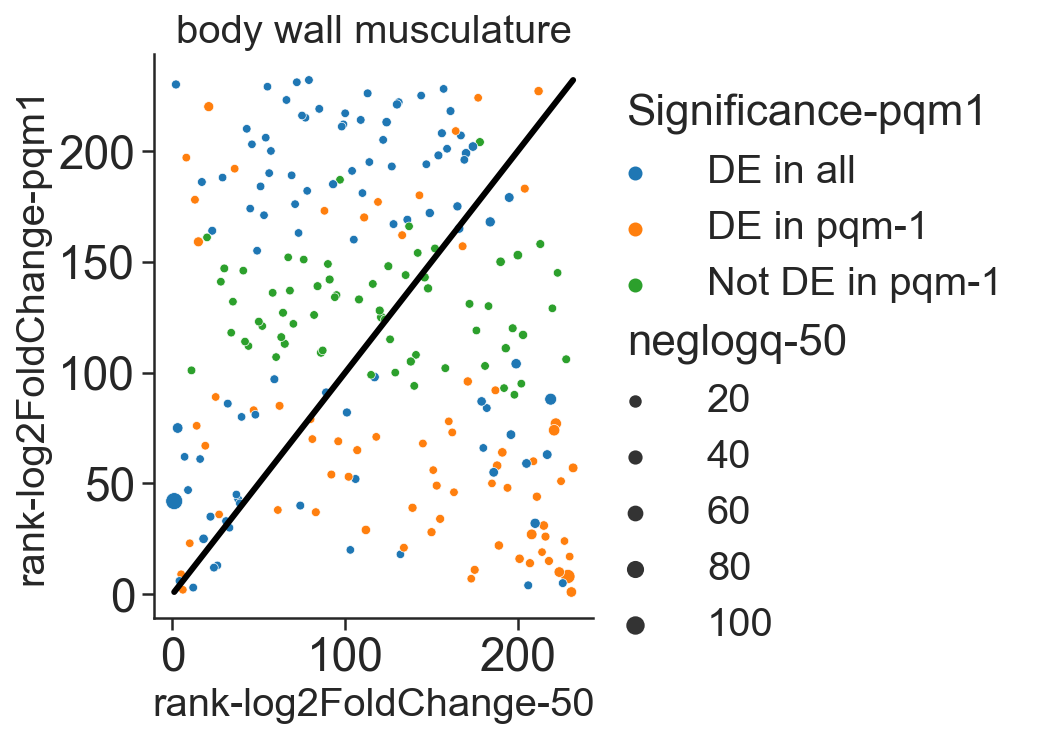

In [12]:
utils.corr_plots(annotated_data, x, y, hue='Significance-pqm1', size='neglogq-50',
                 tissue='body wall musculature', qval=0.05, kind='rank')

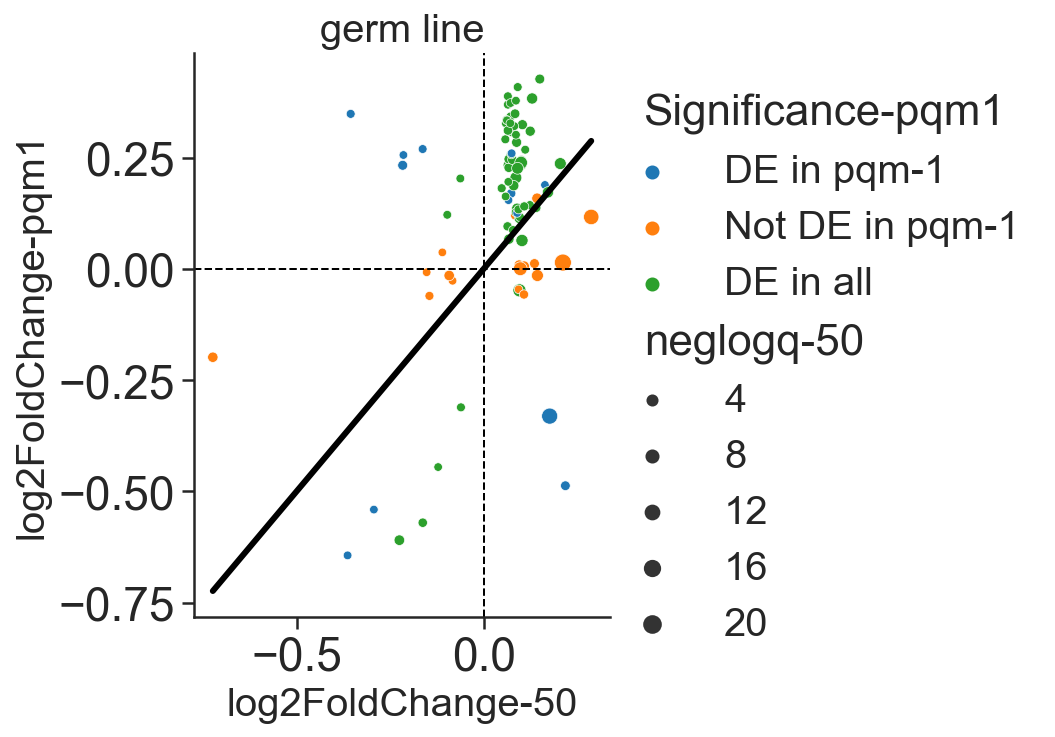

In [13]:
utils.corr_plots(annotated_data, x, y, hue='Significance-pqm1', size='neglogq-50',
                 tissue='germ line', qval=0.05, kind='pearson')

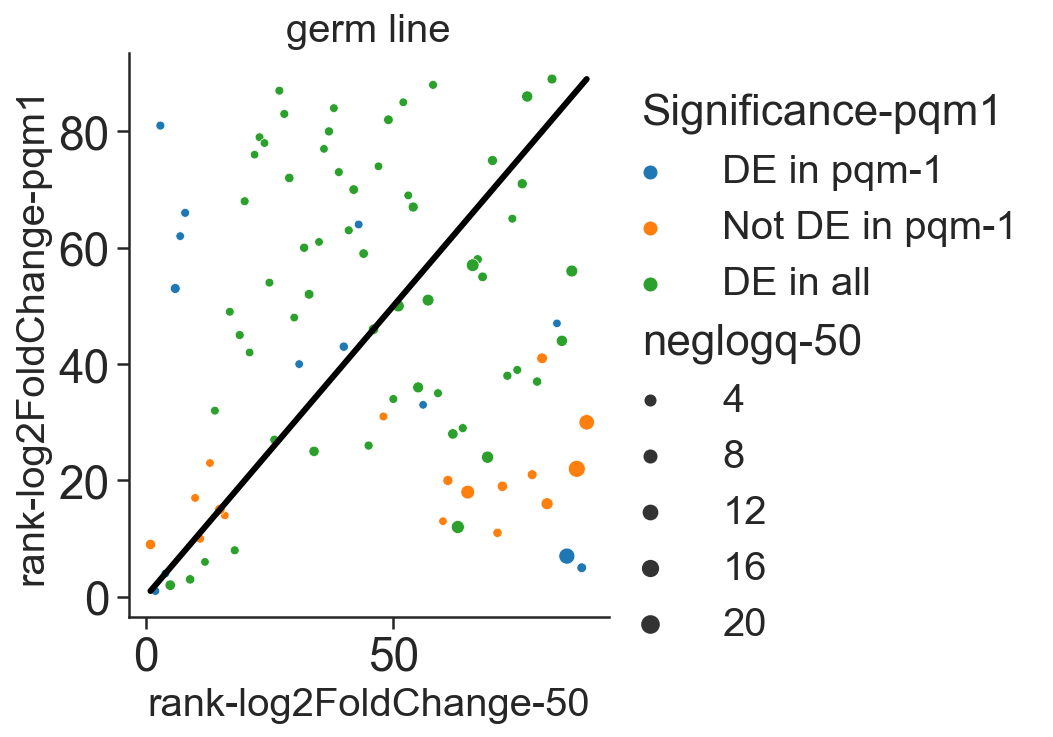

In [14]:
utils.corr_plots(annotated_data, x, y, hue='Significance-pqm1', size='neglogq-50',
                 tissue='germ line', qval=0.05, kind='rank')

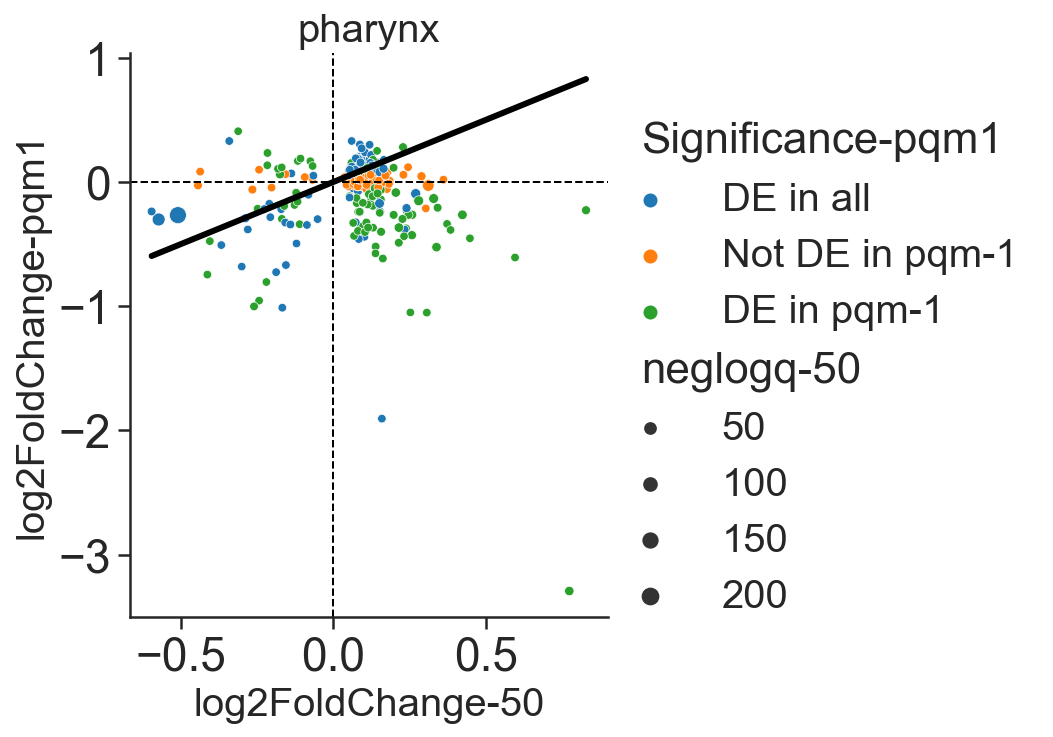

In [15]:
utils.corr_plots(annotated_data, x, y, hue='Significance-pqm1', size='neglogq-50',
                 tissue='pharynx', qval=0.05, kind='pearson')

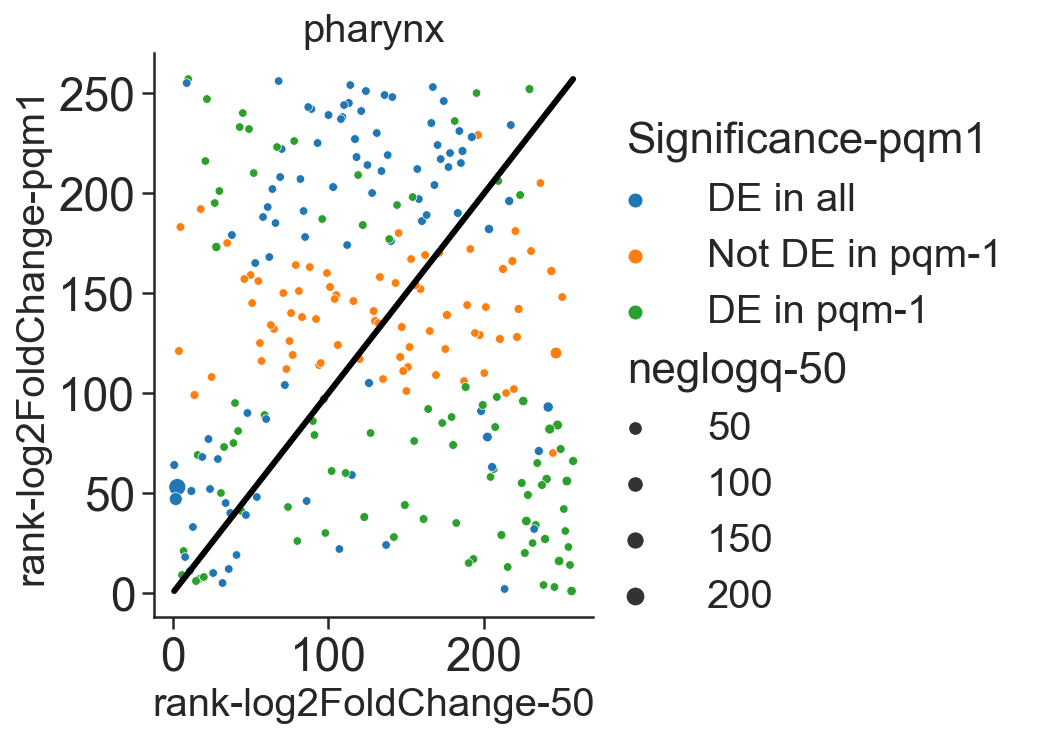

In [16]:
utils.corr_plots(annotated_data, x, y, hue='Significance-pqm1', size='neglogq-50',
                 tissue='pharynx', qval=0.05, kind='rank')